In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [22]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

## Create the two Gaussians dataset

$p_{data} = 0.5 \mathcal{N}(\mu_1, \sigma I)+0.5 \mathcal{N}(-\mu_1, \sigma I)$

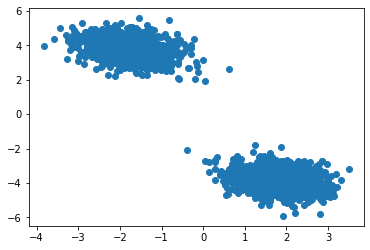

<Figure size 432x288 with 0 Axes>

In [39]:
means = torch.tensor([[1, 1], [-1, -1], [1, -1], [-1, 1], [0,0]])
std = 0.2
size = 1000
mean_scale = 1
means *= mean_scale


data_dim = 1000


#torch.manual_seed(123)
X_0 = 1 * mean_scale + torch.randn((size, 10)) * std
X_1 = -1 * mean_scale + torch.randn((size, 10)) * std

# embed 10-dim manifold to {data_dim}-dim space
W = torch.randn((10, data_dim))
                
X_0 = torch.matmul(X_0, W)
X_1 = torch.matmul(X_1, W)
X_0 += torch.randn_like(X_0) * 0.01
X_1 += torch.randn_like(X_1) * 0.01

X_0 = torch.clip(X_0, -100, 100)
X_1 = torch.clip(X_1, -100, 100)

X = torch.cat([X_0, X_1], dim=0)

# visualize the fisrt two dimensions
plt.scatter(X[:, 0], X[:, 1], label='True data')
plt.show()
plt.clf()

## Construct data loader

In [40]:
class Gaussain_data(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        return self.X[idx], self.Y[idx]
    
train_dataset = Gaussain_data(X=X, Y=Y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

## Construct neural network

In [41]:


def weight_init(shape, mode, fan_in, fan_out):
    if mode == 'xavier_uniform': return np.sqrt(6 / (fan_in + fan_out)) * (torch.rand(*shape) * 2 - 1)
    if mode == 'xavier_normal':  return np.sqrt(2 / (fan_in + fan_out)) * torch.randn(*shape)
    if mode == 'kaiming_uniform': return np.sqrt(3 / fan_in) * (torch.rand(*shape) * 2 - 1)
    if mode == 'kaiming_normal':  return np.sqrt(1 / fan_in) * torch.randn(*shape)
    raise ValueError(f'Invalid init mode "{mode}"')

class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, init_mode='xavier_uniform', init_weight=1, init_bias=0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        init_kwargs = dict(mode=init_mode, fan_in=in_features, fan_out=out_features)
        self.weight = torch.nn.Parameter(weight_init([out_features, in_features], **init_kwargs) * init_weight)
        self.bias = torch.nn.Parameter(weight_init([out_features], **init_kwargs) * init_bias) if bias else None

    def forward(self, x):
        #self.weight.data = self.quan_dequan(self.weight.data)
        x = x @ self.weight.to(x.dtype).t()
        if self.bias is not None:
            x = x.add_(self.bias.to(x.dtype))
        return x

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    def forward(self, x):
        freqs = torch.arange(start=0, end=self.num_channels//2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x

class mlp(nn.Module):
    """
    the common architecture for the score model
    """
    def __init__(self, dim=2, latent_dim=32, std_data=0.5):
        super(mlp, self).__init__()

        self.std_data = std_data
        
        self.latent_dim = latent_dim

        self.fc1 = nn.Linear(dim, latent_dim)
        
        self.emb_layer = PositionalEmbedding(num_channels=latent_dim)
        self.fc_emb = nn.Linear(latent_dim, latent_dim)
        
        self.normalizer_skip = nn.LayerNorm(latent_dim)
        self.normalizer1 = nn.LayerNorm(latent_dim)
        
        self.fc_skip = nn.Linear(dim, latent_dim  )
        self.fc1_skip = nn.Linear(latent_dim, latent_dim )
        
        
        self.fc2 = nn.Linear(latent_dim, latent_dim )
        self.fc3 = nn.Linear(latent_dim , latent_dim )
        self.fc4 = nn.Linear(latent_dim, dim)
        
        #sself.fc5 = nn.Linear(latent_dim, dim)
    def forward(self, x, t):
        c_out = t * std_data/(std_data ** 2 + t ** 2).sqrt()
        c_skip = std_data ** 2/(std_data ** 2 + t ** 2)
        
        t = t.flatten().log() / 4.
        
        x_1 = self.fc1(x) + (self.emb_layer(t))
        
        x_2 = F.relu(x_1)   
        x_3 = F.relu(self.fc2(x_2)) + self.fc1_skip(x_1) # latent_dim -> latent_dim/2
        x_4 = F.relu(self.fc3(x_3)) + self.fc_skip(x)   
        x_4 = self.fc4(x_4)                             # latent_dim/2 -> latent_dim
        #x_4 = self.fc3_old(x_3)
        return c_out * x_4 + c_skip * x


## Training

In [46]:
params = {'lr': 1e-3, 'latent_dim': 32}

model = mlp(dim=data_dim, latent_dim=params['latent_dim'], std_data=1).cuda()
opt = torch.optim.Adam(model.parameters(), lr=params['lr'])
max_t = 50
min_t = 0.001
total_epoch = 200
pfgmpp = True
D = 100
N = data_dim


for epoch in tqdm(range(total_epoch)):
    loss_sum = 0.
    cnt = 0.

    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        var_data = std ** 2 + mean_scale ** 2
        std_data = np.sqrt(var_data)
        # normalize the data such that it's std is 1
        x /= std_data
        
        
        std_data = 1
        opt.zero_grad()
        
        rnd_normal = torch.randn((x.shape[0], 1), device=x.device)
        t = (rnd_normal * 1.2 - 1.2).exp()
        

        r = t * np.sqrt(D).astype(np.float64) # r=sigma\sqrt{D} formula

        # sample noise from perturbation kernel p_r = #
        # Sampling form inverse-beta distribution
        samples_norm = np.random.beta(a=N / 2., b=D / 2.,
                             size=x.shape[0]).astype(np.double)
        inverse_beta = samples_norm / (1 - samples_norm +1e-8)
        inverse_beta = torch.from_numpy(inverse_beta).to(x.device).double()
        # Sampling from p_r(R) by change-of-variable (c.f. Appendix B)
        samples_norm = (r.squeeze() * torch.sqrt(inverse_beta +1e-8)).view(len(samples_norm), -1)
        # Uniformly sample the angle component
        gaussian = torch.randn(x.shape[0], N).to(samples_norm.device)
        unit_gaussian = gaussian / torch.norm(gaussian, p=2, dim=1, keepdim=True)
        # Construct the perturbation 
        x_hat = x + (unit_gaussian * samples_norm).float()
        
        # preconditions
        c_in = 1/(std_data ** 2 + t ** 2).sqrt()
        c_out = t * std_data/(std_data ** 2 + t ** 2).sqrt()
        c_skip = std_data ** 2/(std_data ** 2 + t ** 2)
        
        D_x = model(x_hat * c_in, t)

        weight = (t**2 + std_data ** 2) / (t*std_data) ** 2
        
        loss = torch.sum(weight * ((D_x - x) ** 2), dim=1).mean()
        loss.backward()
        opt.step()

        loss_sum += loss.item()
        cnt += len(x)

    print(f" epoch {epoch}, avg loss:{loss_sum/cnt:.4f}, ")
    

  1%|█▉                                                                                                                                                                                               | 2/200 [00:00<00:16, 11.96it/s]

 epoch 0, avg loss:36.6069, 
 epoch 1, avg loss:31.0051, 
 epoch 2, avg loss:24.3430, 


  3%|█████▊                                                                                                                                                                                           | 6/200 [00:00<00:15, 12.47it/s]

 epoch 3, avg loss:21.2340, 
 epoch 4, avg loss:21.0917, 
 epoch 5, avg loss:20.1190, 


  4%|███████▋                                                                                                                                                                                         | 8/200 [00:00<00:14, 12.84it/s]

 epoch 6, avg loss:20.6188, 
 epoch 7, avg loss:20.1549, 
 epoch 8, avg loss:20.1100, 


  6%|███████████▌                                                                                                                                                                                    | 12/200 [00:00<00:14, 12.93it/s]

 epoch 9, avg loss:20.1979, 
 epoch 10, avg loss:19.5348, 
 epoch 11, avg loss:19.1462, 


  7%|█████████████▍                                                                                                                                                                                  | 14/200 [00:01<00:14, 12.71it/s]

 epoch 12, avg loss:19.0206, 
 epoch 13, avg loss:19.2525, 
 epoch 14, avg loss:18.1478, 


  9%|█████████████████▎                                                                                                                                                                              | 18/200 [00:01<00:13, 13.19it/s]

 epoch 15, avg loss:18.9174, 
 epoch 16, avg loss:19.2450, 
 epoch 17, avg loss:18.2426, 


 10%|███████████████████▏                                                                                                                                                                            | 20/200 [00:01<00:13, 13.28it/s]

 epoch 18, avg loss:17.7557, 
 epoch 19, avg loss:16.8574, 
 epoch 20, avg loss:18.1765, 


 12%|███████████████████████                                                                                                                                                                         | 24/200 [00:01<00:12, 13.61it/s]

 epoch 21, avg loss:20.2128, 
 epoch 22, avg loss:16.5185, 
 epoch 23, avg loss:16.2178, 


 13%|████████████████████████▉                                                                                                                                                                       | 26/200 [00:01<00:12, 13.70it/s]

 epoch 24, avg loss:15.7638, 
 epoch 25, avg loss:15.4334, 
 epoch 26, avg loss:16.7170, 


 15%|████████████████████████████▊                                                                                                                                                                   | 30/200 [00:02<00:12, 13.76it/s]

 epoch 27, avg loss:16.9666, 
 epoch 28, avg loss:16.3576, 
 epoch 29, avg loss:17.1013, 


 16%|██████████████████████████████▋                                                                                                                                                                 | 32/200 [00:02<00:12, 13.71it/s]

 epoch 30, avg loss:14.3430, 
 epoch 31, avg loss:12.9214, 
 epoch 32, avg loss:12.5924, 


 18%|██████████████████████████████████▌                                                                                                                                                             | 36/200 [00:02<00:11, 13.90it/s]

 epoch 33, avg loss:12.3282, 
 epoch 34, avg loss:12.6093, 
 epoch 35, avg loss:15.2765, 


 19%|████████████████████████████████████▍                                                                                                                                                           | 38/200 [00:02<00:11, 14.01it/s]

 epoch 36, avg loss:11.6785, 
 epoch 37, avg loss:11.0161, 
 epoch 38, avg loss:11.7066, 


 21%|████████████████████████████████████████▎                                                                                                                                                       | 42/200 [00:03<00:11, 14.06it/s]

 epoch 39, avg loss:15.6462, 
 epoch 40, avg loss:14.8114, 
 epoch 41, avg loss:12.3047, 


 22%|██████████████████████████████████████████▏                                                                                                                                                     | 44/200 [00:03<00:11, 13.40it/s]

 epoch 42, avg loss:11.1432, 
 epoch 43, avg loss:10.8160, 
 epoch 44, avg loss:10.1215, 


 24%|██████████████████████████████████████████████                                                                                                                                                  | 48/200 [00:03<00:12, 12.65it/s]

 epoch 45, avg loss:10.9285, 
 epoch 46, avg loss:10.4434, 
 epoch 47, avg loss:10.4883, 


 25%|████████████████████████████████████████████████                                                                                                                                                | 50/200 [00:03<00:11, 13.09it/s]

 epoch 48, avg loss:10.1055, 
 epoch 49, avg loss:10.0823, 
 epoch 50, avg loss:10.2469, 


 27%|███████████████████████████████████████████████████▊                                                                                                                                            | 54/200 [00:04<00:10, 13.57it/s]

 epoch 51, avg loss:10.6514, 
 epoch 52, avg loss:11.4027, 
 epoch 53, avg loss:11.0790, 


 28%|█████████████████████████████████████████████████████▊                                                                                                                                          | 56/200 [00:04<00:10, 13.73it/s]

 epoch 54, avg loss:11.2223, 
 epoch 55, avg loss:10.3185, 
 epoch 56, avg loss:10.5214, 


 30%|█████████████████████████████████████████████████████████▌                                                                                                                                      | 60/200 [00:04<00:10, 13.78it/s]

 epoch 57, avg loss:9.7696, 
 epoch 58, avg loss:9.6210, 
 epoch 59, avg loss:9.5846, 


 31%|███████████████████████████████████████████████████████████▌                                                                                                                                    | 62/200 [00:04<00:10, 13.66it/s]

 epoch 60, avg loss:9.8431, 
 epoch 61, avg loss:9.8571, 
 epoch 62, avg loss:10.6502, 


 33%|███████████████████████████████████████████████████████████████▎                                                                                                                                | 66/200 [00:04<00:09, 13.65it/s]

 epoch 63, avg loss:10.5921, 
 epoch 64, avg loss:13.6727, 
 epoch 65, avg loss:10.9595, 


 34%|█████████████████████████████████████████████████████████████████▎                                                                                                                              | 68/200 [00:05<00:09, 13.61it/s]

 epoch 66, avg loss:9.8494, 
 epoch 67, avg loss:9.6927, 
 epoch 68, avg loss:9.4740, 


 36%|█████████████████████████████████████████████████████████████████████                                                                                                                           | 72/200 [00:05<00:09, 13.69it/s]

 epoch 69, avg loss:9.9736, 
 epoch 70, avg loss:10.9324, 
 epoch 71, avg loss:10.7570, 


 37%|███████████████████████████████████████████████████████████████████████                                                                                                                         | 74/200 [00:05<00:09, 13.63it/s]

 epoch 72, avg loss:10.1253, 
 epoch 73, avg loss:9.5083, 
 epoch 74, avg loss:9.5409, 


 39%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 78/200 [00:05<00:08, 13.96it/s]

 epoch 75, avg loss:9.3182, 
 epoch 76, avg loss:9.3263, 
 epoch 77, avg loss:9.4197, 


 40%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 80/200 [00:05<00:08, 13.90it/s]

 epoch 78, avg loss:9.3231, 
 epoch 79, avg loss:10.4849, 
 epoch 80, avg loss:10.3559, 


 42%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 84/200 [00:06<00:08, 14.24it/s]

 epoch 81, avg loss:10.1668, 
 epoch 82, avg loss:9.4279, 
 epoch 83, avg loss:10.1740, 


 43%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 86/200 [00:06<00:08, 14.22it/s]

 epoch 84, avg loss:9.8528, 
 epoch 85, avg loss:9.1653, 
 epoch 86, avg loss:8.9770, 


 45%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 90/200 [00:06<00:07, 14.22it/s]

 epoch 87, avg loss:9.8126, 
 epoch 88, avg loss:9.3203, 
 epoch 89, avg loss:9.1576, 


 46%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 92/200 [00:06<00:07, 14.05it/s]

 epoch 90, avg loss:9.5361, 
 epoch 91, avg loss:10.0939, 
 epoch 92, avg loss:9.2526, 


 48%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 96/200 [00:07<00:07, 13.95it/s]

 epoch 93, avg loss:9.9739, 
 epoch 94, avg loss:9.3838, 
 epoch 95, avg loss:9.1090, 


 49%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 98/200 [00:07<00:07, 13.65it/s]

 epoch 96, avg loss:8.8291, 
 epoch 97, avg loss:8.9971, 
 epoch 98, avg loss:8.9721, 


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 102/200 [00:07<00:07, 13.42it/s]

 epoch 99, avg loss:9.0399, 
 epoch 100, avg loss:9.4500, 
 epoch 101, avg loss:10.5469, 


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 104/200 [00:07<00:07, 13.24it/s]

 epoch 102, avg loss:9.3499, 
 epoch 103, avg loss:9.3905, 
 epoch 104, avg loss:9.8937, 


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 108/200 [00:07<00:06, 13.42it/s]

 epoch 105, avg loss:9.3763, 
 epoch 106, avg loss:9.2831, 
 epoch 107, avg loss:8.7809, 


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 110/200 [00:08<00:06, 13.36it/s]

 epoch 108, avg loss:8.8939, 
 epoch 109, avg loss:9.4812, 
 epoch 110, avg loss:9.6161, 


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 114/200 [00:08<00:06, 13.30it/s]

 epoch 111, avg loss:10.4176, 
 epoch 112, avg loss:10.8159, 
 epoch 113, avg loss:10.0753, 


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 116/200 [00:08<00:06, 13.26it/s]

 epoch 114, avg loss:9.3947, 
 epoch 115, avg loss:9.2482, 
 epoch 116, avg loss:9.4699, 


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 120/200 [00:08<00:05, 13.36it/s]

 epoch 117, avg loss:9.1762, 
 epoch 118, avg loss:9.1504, 
 epoch 119, avg loss:8.7419, 


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 122/200 [00:09<00:05, 13.27it/s]

 epoch 120, avg loss:9.3860, 
 epoch 121, avg loss:8.8272, 
 epoch 122, avg loss:9.0798, 


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 126/200 [00:09<00:05, 13.43it/s]

 epoch 123, avg loss:9.4810, 
 epoch 124, avg loss:9.4897, 
 epoch 125, avg loss:9.0970, 


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 128/200 [00:09<00:05, 13.44it/s]

 epoch 126, avg loss:8.8385, 
 epoch 127, avg loss:9.2969, 
 epoch 128, avg loss:9.2818, 


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 132/200 [00:09<00:04, 13.83it/s]

 epoch 129, avg loss:9.2460, 
 epoch 130, avg loss:10.7374, 
 epoch 131, avg loss:9.3798, 


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 134/200 [00:09<00:04, 13.83it/s]

 epoch 132, avg loss:8.6967, 
 epoch 133, avg loss:9.0375, 
 epoch 134, avg loss:11.0975, 


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 138/200 [00:10<00:04, 14.12it/s]

 epoch 135, avg loss:10.3140, 
 epoch 136, avg loss:10.2013, 
 epoch 137, avg loss:9.5374, 


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 140/200 [00:10<00:04, 14.00it/s]

 epoch 138, avg loss:9.3758, 
 epoch 139, avg loss:8.9822, 
 epoch 140, avg loss:8.8276, 


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 144/200 [00:10<00:04, 13.93it/s]

 epoch 141, avg loss:8.6949, 
 epoch 142, avg loss:8.6952, 
 epoch 143, avg loss:9.0222, 


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 146/200 [00:10<00:03, 14.02it/s]

 epoch 144, avg loss:8.7179, 
 epoch 145, avg loss:8.5894, 
 epoch 146, avg loss:9.3991, 


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 150/200 [00:11<00:03, 13.84it/s]

 epoch 147, avg loss:10.0459, 
 epoch 148, avg loss:11.0121, 
 epoch 149, avg loss:10.4991, 


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 152/200 [00:11<00:03, 13.87it/s]

 epoch 150, avg loss:9.3579, 
 epoch 151, avg loss:8.7361, 
 epoch 152, avg loss:8.6699, 


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 156/200 [00:11<00:03, 13.47it/s]

 epoch 153, avg loss:8.4603, 
 epoch 154, avg loss:8.4500, 
 epoch 155, avg loss:8.9261, 


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 158/200 [00:11<00:03, 13.47it/s]

 epoch 156, avg loss:9.4640, 
 epoch 157, avg loss:8.5354, 
 epoch 158, avg loss:8.8763, 


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 162/200 [00:11<00:02, 13.59it/s]

 epoch 159, avg loss:8.8349, 
 epoch 160, avg loss:8.5860, 
 epoch 161, avg loss:9.1785, 


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 164/200 [00:12<00:02, 13.08it/s]

 epoch 162, avg loss:10.1194, 
 epoch 163, avg loss:9.5067, 
 epoch 164, avg loss:8.8859, 


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 168/200 [00:12<00:02, 13.41it/s]

 epoch 165, avg loss:8.8768, 
 epoch 166, avg loss:8.4527, 
 epoch 167, avg loss:9.4086, 


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 170/200 [00:12<00:02, 13.60it/s]

 epoch 168, avg loss:8.4919, 
 epoch 169, avg loss:8.2930, 
 epoch 170, avg loss:9.2663, 


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 174/200 [00:12<00:01, 13.78it/s]

 epoch 171, avg loss:10.1312, 
 epoch 172, avg loss:8.6187, 
 epoch 173, avg loss:8.8371, 


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 176/200 [00:12<00:01, 13.82it/s]

 epoch 174, avg loss:9.3333, 
 epoch 175, avg loss:8.3742, 
 epoch 176, avg loss:8.3680, 


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 180/200 [00:13<00:01, 13.93it/s]

 epoch 177, avg loss:8.9945, 
 epoch 178, avg loss:8.7974, 
 epoch 179, avg loss:8.8790, 


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 182/200 [00:13<00:01, 14.02it/s]

 epoch 180, avg loss:8.7491, 
 epoch 181, avg loss:8.5458, 
 epoch 182, avg loss:8.6048, 


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 186/200 [00:13<00:01, 13.87it/s]

 epoch 183, avg loss:8.8514, 
 epoch 184, avg loss:8.5877, 
 epoch 185, avg loss:8.8325, 


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 188/200 [00:13<00:00, 13.97it/s]

 epoch 186, avg loss:9.1352, 
 epoch 187, avg loss:9.3230, 
 epoch 188, avg loss:8.5869, 


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 192/200 [00:14<00:00, 13.58it/s]

 epoch 189, avg loss:8.8711, 
 epoch 190, avg loss:8.1817, 
 epoch 191, avg loss:8.6247, 


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 194/200 [00:14<00:00, 13.17it/s]

 epoch 192, avg loss:8.6290, 
 epoch 193, avg loss:8.5247, 
 epoch 194, avg loss:8.2779, 


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 198/200 [00:14<00:00, 13.44it/s]

 epoch 195, avg loss:9.0443, 
 epoch 196, avg loss:8.7734, 
 epoch 197, avg loss:8.1586, 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.58it/s]

 epoch 198, avg loss:8.2897, 
 epoch 199, avg loss:8.7383, 


## Sampling

In [47]:
np.random.seed(123)
torch.manual_seed(123)

min_t = 0.001
num_steps = 50
sample_size = 2000
S_churn = 0
S_min = 0.01
S_max = 5
S_noise = 1.

rho = 7
latents = torch.randn(sample_size, data_dim)

# Time step discretization.
step_indices = torch.arange(num_steps, dtype=torch.float, device=latents.device)
t_steps = (max_t ** (1 / rho) + step_indices / (num_steps - 1) * (min_t ** (1 / rho) - max_t ** (1 / rho))) ** rho
t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]).cuda().float() # t_N = 0

# Main sampling loop.
std_data = 1

if pfgmpp:
    r_max = t_steps[0] * np.sqrt(D).astype(np.float64) # r=sigma\sqrt{D} formula

    # = sample noise from perturbation kernel p_r = #
    # Sampling form inverse-beta distribution
    samples_norm = np.random.beta(a=N / 2., b=D / 2.,
                         size=sample_size).astype(np.double)
    inverse_beta = samples_norm / (1 - samples_norm +1e-8)
    inverse_beta = torch.from_numpy(inverse_beta).to(x.device).double()
    # Sampling from p_r(R) by change-of-variable (c.f. Appendix B)
    samples_norm = (r_max.squeeze() * torch.sqrt(inverse_beta +1e-8)).view(len(samples_norm), -1)
    # Uniformly sample the angle component
    gaussian = torch.randn(sample_size, N).to(samples_norm.device)
    unit_gaussian = gaussian / torch.norm(gaussian, p=2, dim=1, keepdim=True)
    # Construct the perturbation 
    x_next = (unit_gaussian * samples_norm).float()
else:
    x_next = latents.cuda() * t_steps[0]

#collect_noisy = np.zeros((num_steps, len(idx_out), 2))

for i, (t_cur, t_next) in tqdm(enumerate(zip(t_steps[:-1], t_steps[1:]))):
    #collect_noisy[i, :, :] = x_next[idx_out, :].detach().cpu().numpy()
    x_cur = x_next

    # Increase noise temporarily.
    gamma = S_churn / num_steps if S_min <= t_cur <= S_max else 0
    t_hat = t_cur + gamma * t_cur
    x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * torch.randn_like(x_cur)

    # Euler step.
    # preconditions
    c_in = 1/(std_data ** 2 + t_hat ** 2).sqrt()
    denoised = model(x_hat * c_in, t_hat)
    d_cur = (x_hat - denoised) / t_hat
    x_next = x_hat + (t_next - t_hat) * d_cur

    # Apply 2nd order correction.
    if i < num_steps - 1:
        # preconditions
        c_in = 1/(std_data ** 2 + t_next ** 2).sqrt()
        denoised = model(x_next * c_in, t_next)
        d_prime = (x_next - denoised) / t_next
        x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
    



50it [00:00, 588.86it/s]


/tmp/ipykernel_3183780/3039846937.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(title +'.png', bbox='tight', dpi=300)


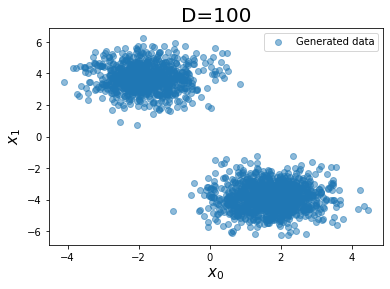

/tmp/ipykernel_3183780/3039846937.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(title +'.png', bbox='tight', dpi=300)


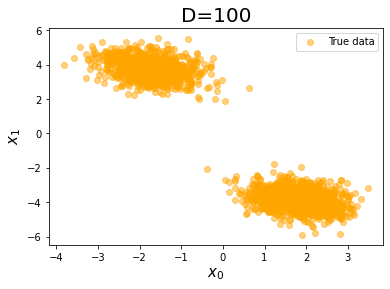

<Figure size 432x288 with 0 Axes>

In [48]:
var_data = std ** 2 + mean_scale ** 2
std_data = np.sqrt(var_data)
#std_data = torch.std(X.view(-1)).numpy()
generated_X = x_next.detach().cpu().numpy() * std_data


#plt.scatter(X[:, 0], X[:, 1], label='True data', alpha=0.5, color='orange')
plt.scatter(generated_X[:, 0], generated_X[:, 1], label='Generated data', alpha=0.5)

#plt.scatter(generated_X[idx_out, 0], generated_X[idx_out, 1], label='out')

title = f'$D=\infty$' if pfgmpp is False else f'D={D}'

#title = 'True data'
plt.title(title, fontsize=20)
plt.xlabel('$x_0$', fontsize=15)
plt.ylabel('$x_1$', fontsize=15)
plt.legend()
plt.savefig(title +'.png', bbox='tight', dpi=300)
plt.show()
plt.clf()

var_data = std ** 2 + mean_scale ** 2
std_data = np.sqrt(var_data)
#std_data = torch.std(X.view(-1)).numpy()
generated_X = x_next.detach().cpu().numpy() * std_data


plt.scatter(X[:, 0], X[:, 1], label='True data', alpha=0.5, color='orange')
#plt.scatter(generated_X[:, 0], generated_X[:, 1], label='Generated data', alpha=0.5)

#plt.scatter(generated_X[idx_out, 0], generated_X[idx_out, 1], label='out')

title = f'$D=\infty$' if pfgmpp is False else f'D={D}'

#title = 'True data'
plt.title(title, fontsize=20)
plt.xlabel('$x_0$', fontsize=15)
plt.ylabel('$x_1$', fontsize=15)
plt.legend()
plt.savefig(title +'.png', bbox='tight', dpi=300)
plt.show()
plt.clf()

In [49]:
mmd = MMD_loss()
m = mmd.forward(X, torch.from_numpy(generated_X))

print(m)

tensor(0.0586)
